# Learned post processing

In the following exercise we will train a notebook for learning a post processing

Given $N$ training pairs $S = \{(y^\delta_i, x^\dagger_i)\}$ we will train the network by minimizing the loss function 

$$L_S(\Theta) = \sum_{i=1}^N \Vert \varphi_\Theta(A^\dagger y^\delta_i) - x_i^\dagger \Vert$$



## Load the data

In [0]:
import numpy as np
from skimage.transform import radon, iradon

n, m = 28, 28

###############################################
# TODO: Set number of angles
angles = 5
###############################################

detectors = 40

theta = np.linspace(0.0, 180.0, angles, endpoint=False)

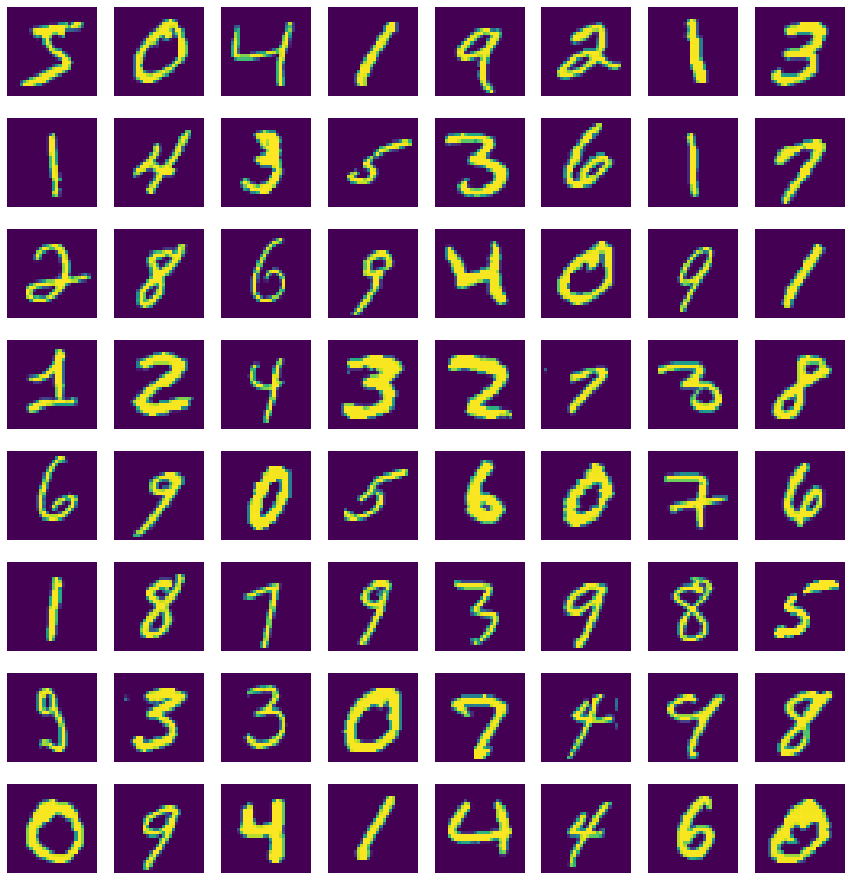

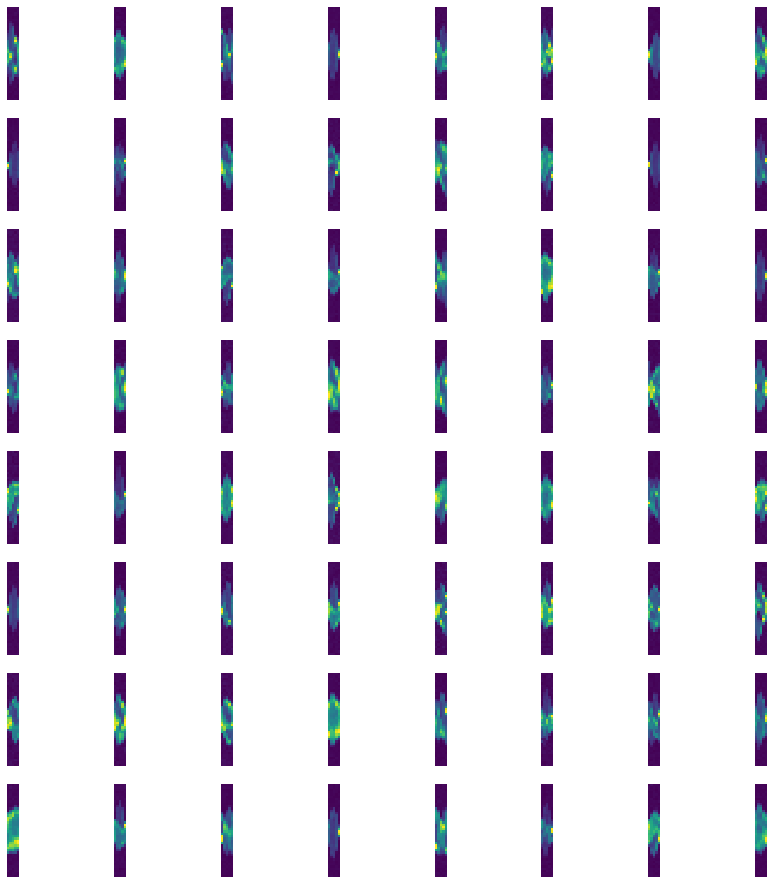

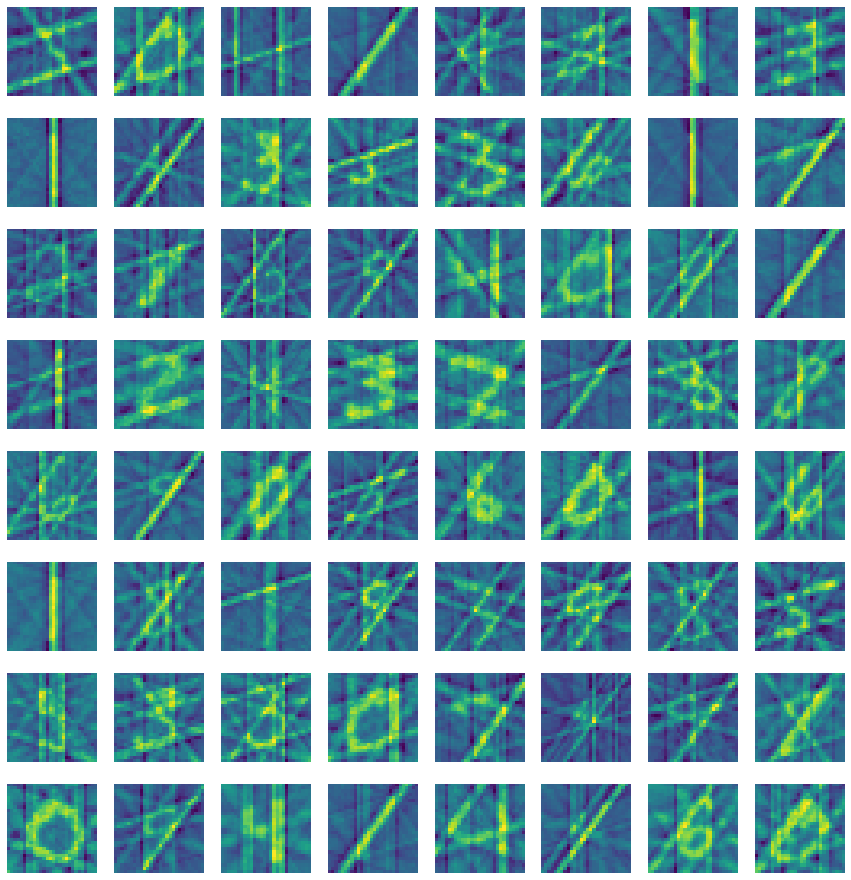

In [6]:
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset

batch_size = 64

transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


def forward(phantom):
    sinogram = radon(phantom.squeeze(), theta, circle=False)
    sinogram += 0.1 * np.random.normal(size=sinogram.shape)
    return sinogram


class SinogramData(Dataset):
    def __init__(self, dataset, forward):
        super(SinogramData, self).__init__()
        self.dataset = dataset
        self.sinograms = []
        self.fbps = []

        for i in range(len(self.dataset)):
            x = self.dataset[i][0]
            self.sinograms.append(torch.tensor(forward(x), dtype=torch.float32))
            self.fbps.append(torch.tensor(iradon(self.sinograms[i], theta, circle=False), dtype=torch.float32))

        self.forward = forward
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        y = self.sinograms[idx]
        z = self.fbps[idx]
        return x, y, z
    
# datasets (MNIST)
mnist_train = SinogramData(datasets.MNIST('/data', train=True, download=True, transform=transform_train), forward)
mnist_test  = SinogramData(datasets.MNIST('/data', train=False, download=True, transform=transform_test), forward)

# dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)


def visualize_batch(batch, ncols=8):
    nrows = (batch.shape[0] + ncols - 1) // ncols
    plt.figure(figsize=(15, 2 * nrows))
    for i in range(batch.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(batch[i].squeeze())
        plt.axis('off')
    plt.show()


x_batch, y_batch, z_batch = next(iter(train_loader))
visualize_batch(x_batch)
visualize_batch(y_batch)
visualize_batch(z_batch)

## Create the neural network

In [0]:
import torch.nn as nn
import torch.nn.functional as F


# BELLOW YOU CAN FIND THE TINY NETWORK BY THE STUDENT THAT PRESENTED AT THE END THE GREAT PERFORMANCE BUT THERE WAS UNFORTUNATELY AN ERROR THAT I DIDN'T SEE AT THAT MOMENT
# In the forward method of the model, it uses the ground-truth as the input due to a bug. This means instead of processing the FBP image (noisy with artefacts) was processing the clean x,
# which explains the great results :(

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, 3, stride=2, padding=1)
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv2 = nn.Conv2d(10, 1, 3, padding=1)
#         self.non_lin = nn.Tanh()

#     def forward(self, z):
#         z = x.view(-1, 1, n, m)
#         z = self.conv1(z)
#         z = self.up(z)
#         z = self.non_lin(z)
#         z = self.conv2(z)
#         return z


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
                                  
    def forward(self, x):
        x = self.conv3(self.conv2(self.conv1(x)))
        return x
    
                                  
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0 = ConvBlock(1, 4)
        self.conv1 = ConvBlock(4, 8, stride=2)
        self.conv2 = ConvBlock(8, 16, stride=2)
        self.conv3 = ConvBlock(16, 16)
        self.conv4 = ConvBlock(16, 8)
        self.conv5 = ConvBlock(8, 4)
        self.conv6 = nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, x0):
        x0 = x0.view(-1, 1, n, m)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.up(x)
        x = self.conv4(x)
        x = self.up(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return F.sigmoid(x)

model = Autoencoder()

## Set the hyperparameters, the loss function and the optimizer

In [9]:
###############################################
# TODO: Choose the learning rate
lr = 0.01
###############################################

# number of epochs
n_epochs = 10

###############################################
# TODO: Choose the loss function
loss_function = nn.MSELoss()
###############################################


###############################################
# TODO: Choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
###############################################

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Train the network

In [10]:
from skimage.measure import compare_psnr

model.to(device)

# iterate over epochs
for i in range(n_epochs):
  
    train_loss = 0.0
    test_loss = 0.0

    model.train()
    # iterate over batches
    for j, (x, y, z) in enumerate(train_loader):
        x, y, z = x.to(device), y.to(device), z.to(device)

        ######################################################
        # TODO: Compute the output and do the backprop
        # 1) zero the gradients
        # 2) compute the output of the model
        # 3) compute the loss function
        # 4) backpropagate
        # 5) do a gradient step
        optimizer.zero_grad()
        output = model(z)
        loss = loss_function(output, x)
        loss.backward()
        optimizer.step()
        ######################################################

        train_loss += loss.item() * x.shape[0]
        if j % 200 == 0:
            print('%d/%d' % (j, len(train_loader)))
      
    
    model.eval()
    # iterate on batches
    for x, y, z in test_loader:
        x, y, z = x.to(device), y.to(device), z.to(device)
        
        ######################################################
        # TODO: Evaluate the performance of the current parameters
        # 1) compute the output of the network
        # 2) compute the loss function
        output = model(z)
        loss = loss_function(output, x)
        ######################################################

        test_loss += loss.item() * x.shape[0]

    train_loss /= len(mnist_train)
    test_loss /= len(mnist_test)

    print('epoch: %d train-error: %.5f test-error: %.4f' % (i, train_loss, test_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0/938
200/938
400/938
600/938
800/938
epoch: 0 train-error: 0.02132 test-error: 0.0136
0/938
200/938
400/938
600/938
800/938
epoch: 1 train-error: 0.00946 test-error: 0.0102
0/938
200/938
400/938
600/938
800/938
epoch: 2 train-error: 0.00844 test-error: 0.0092
0/938
200/938
400/938
600/938
800/938
epoch: 3 train-error: 0.00790 test-error: 0.0083
0/938
200/938
400/938
600/938
800/938
epoch: 4 train-error: 0.00752 test-error: 0.0080
0/938
200/938
400/938
600/938
800/938
epoch: 5 train-error: 0.00724 test-error: 0.0079
0/938
200/938
400/938
600/938
800/938
epoch: 6 train-error: 0.00702 test-error: 0.0078
0/938
200/938
400/938
600/938
800/938
epoch: 7 train-error: 0.00682 test-error: 0.0087
0/938
200/938
400/938
600/938
800/938
epoch: 8 train-error: 0.00664 test-error: 0.0085
0/938
200/938
400/938
600/938
800/938
epoch: 9 train-error: 0.00650 test-error: 0.0083


In [11]:
def PSNR(imtrue, imother):
    return compare_psnr(imtrue, imother, data_range=imtrue.max()-imtrue.min())

model.eval()
# iterate on batches

psnr = 0
for x, y, z in test_loader:
    x, y, z = x.to(device), y.to(device), z.to(device)
    outputs = model(z)
    
    for j in range(x.shape[0]):
        psnr += PSNR(x[j].cpu().numpy(), outputs[j].detach().cpu().numpy())
        
psnr /= len(mnist_test)
print(psnr)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


21.218716949113844


## Show some examples

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


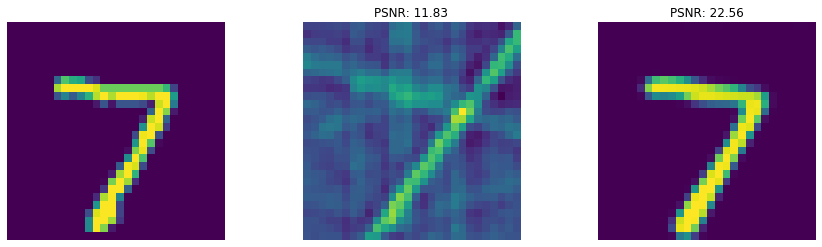

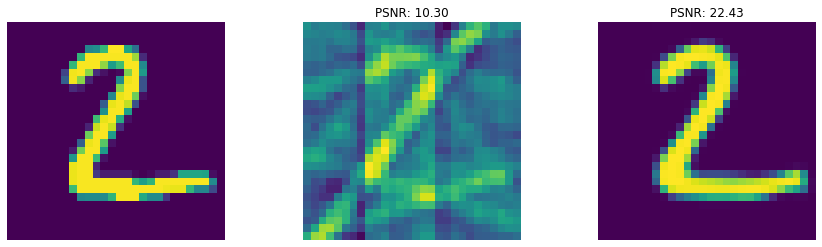

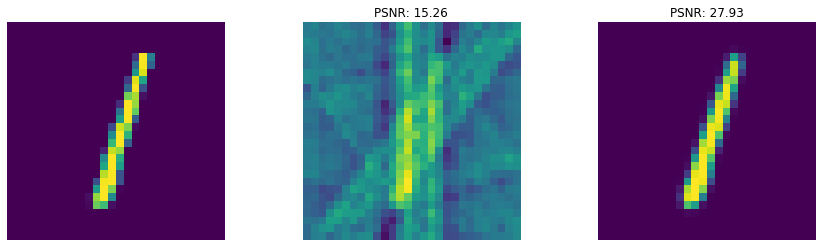

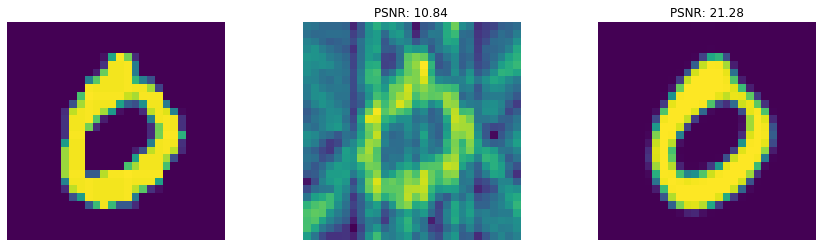

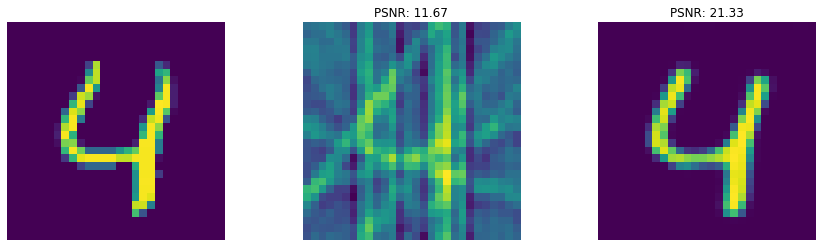

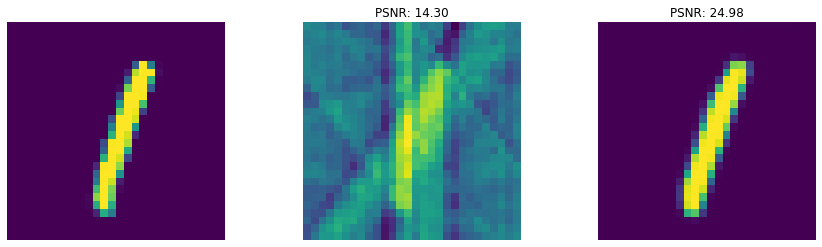

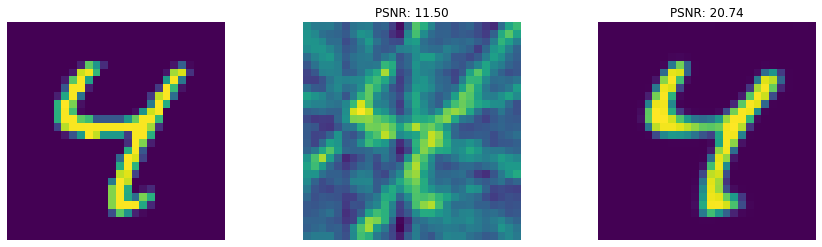

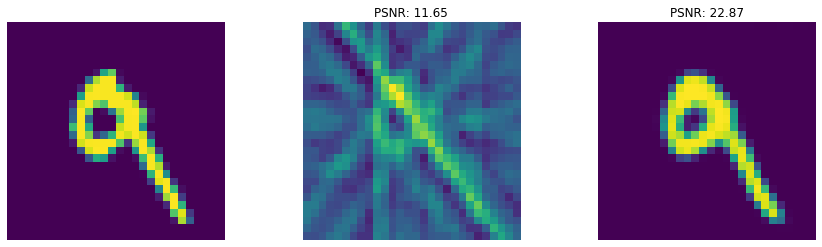

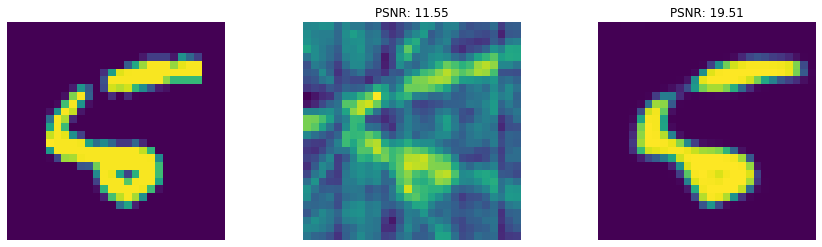

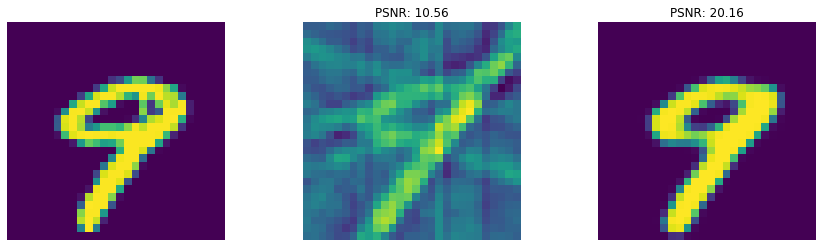

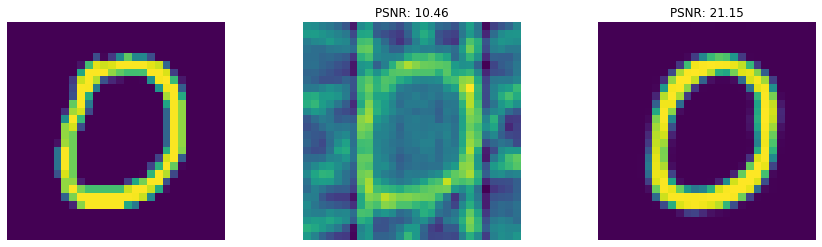

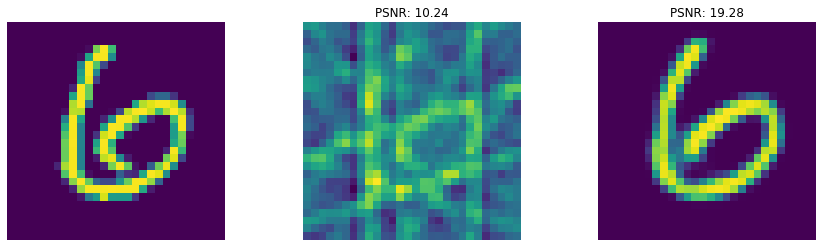

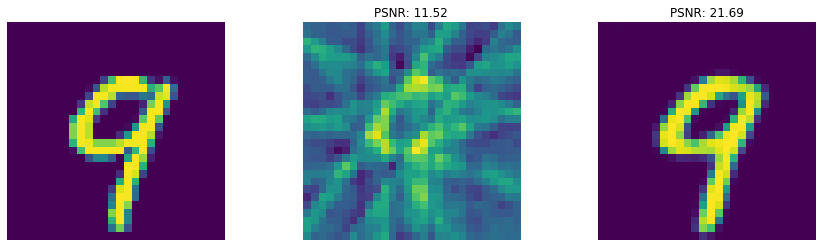

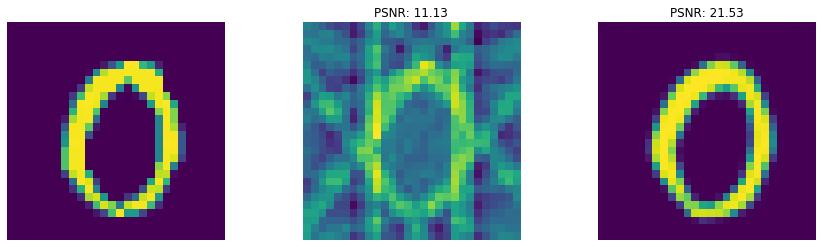

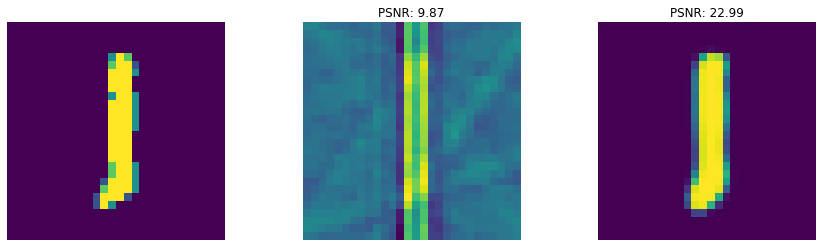

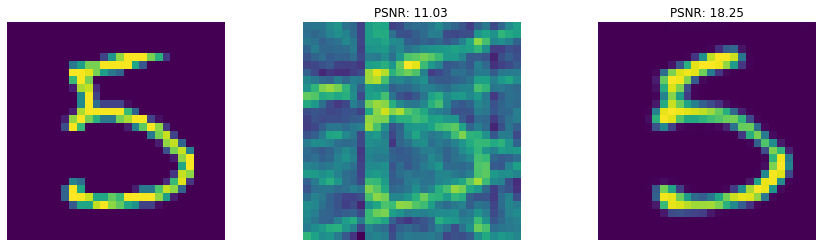

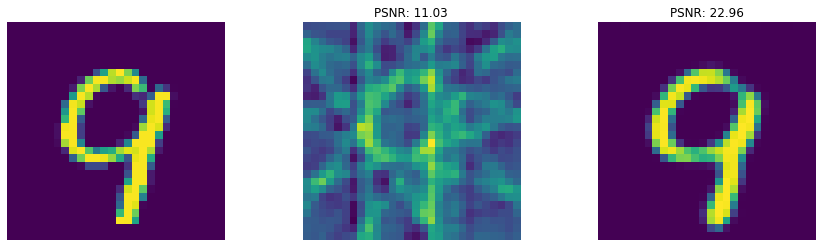

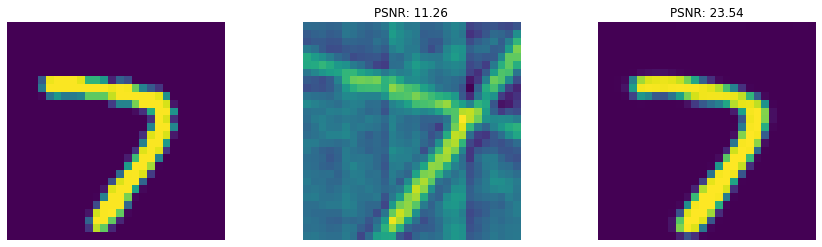

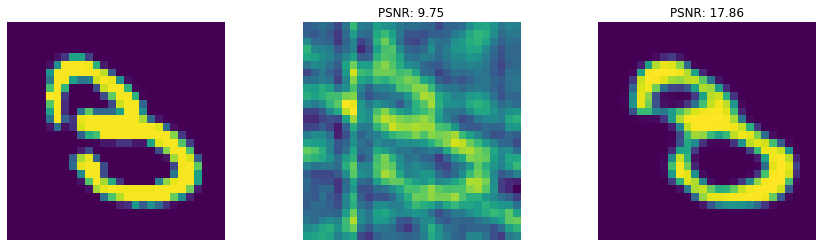

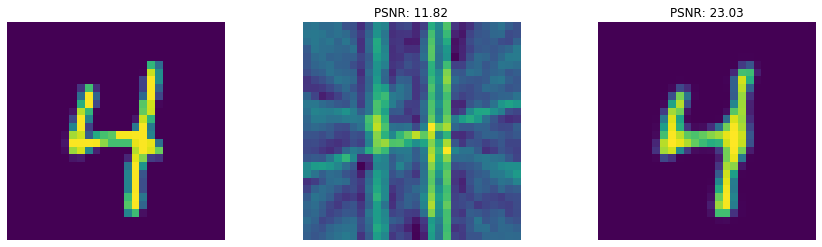

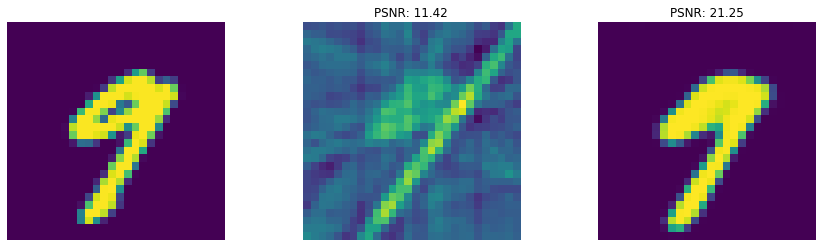

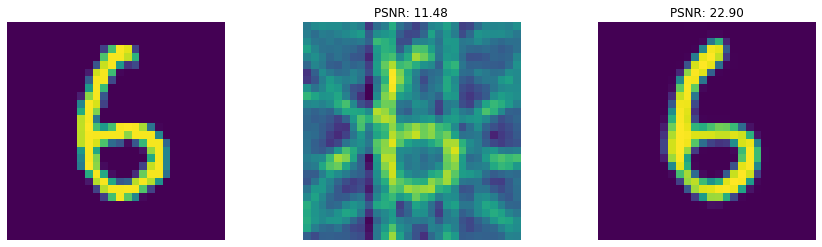

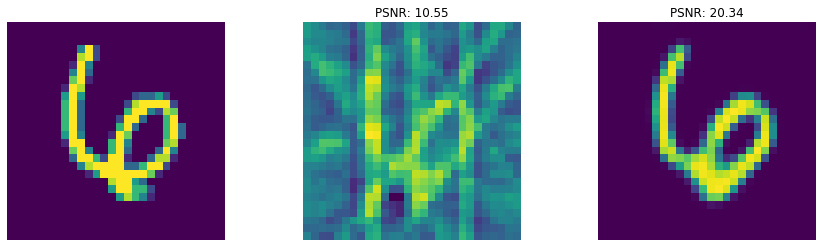

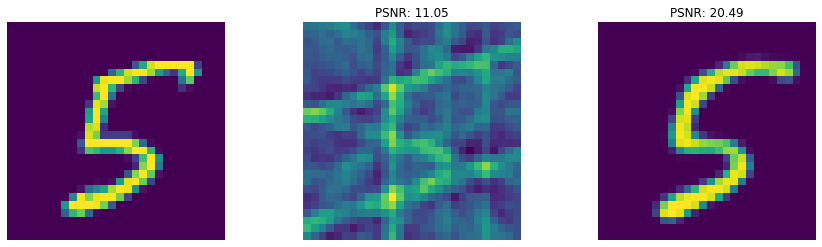

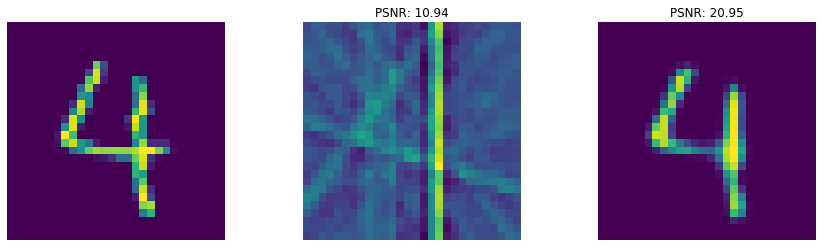

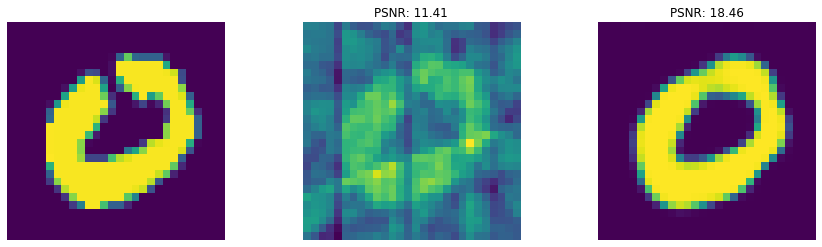

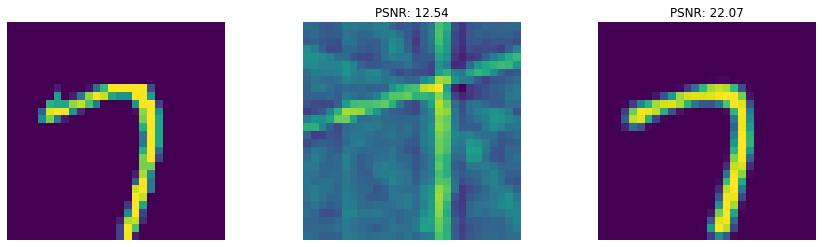

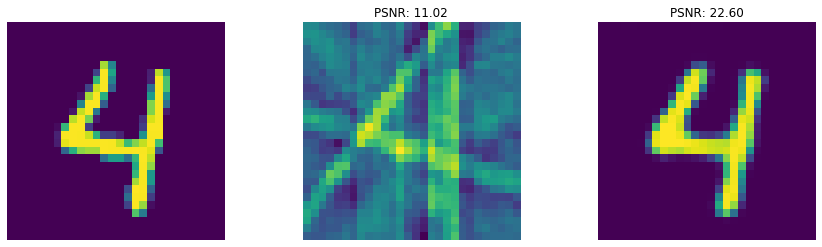

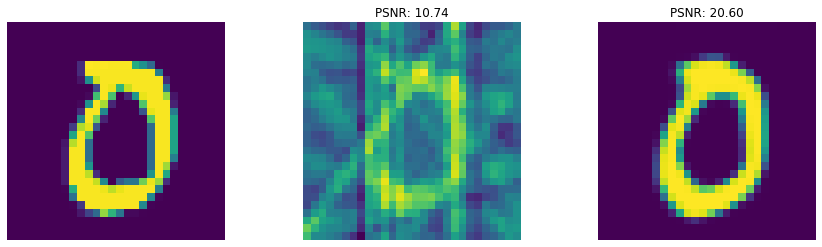

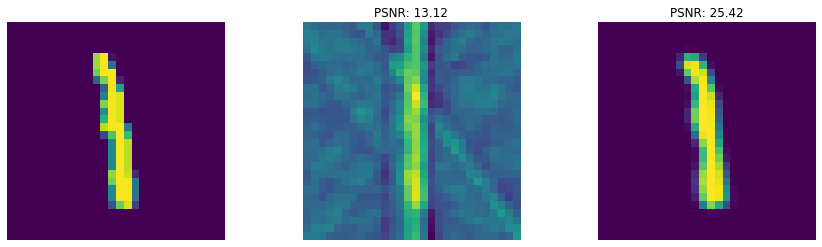

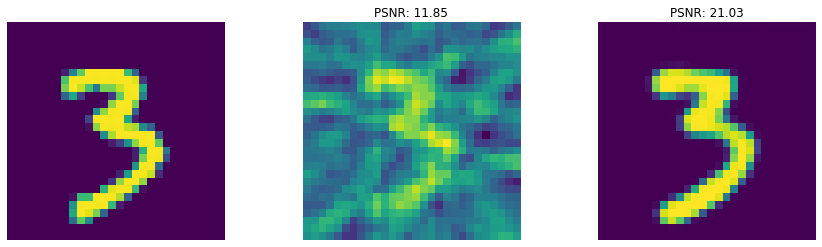

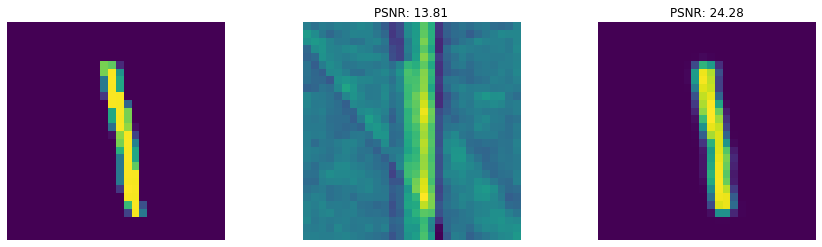

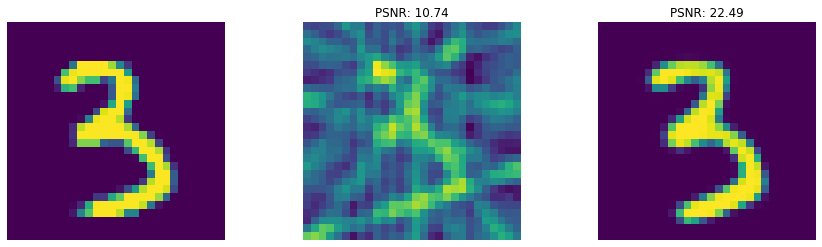

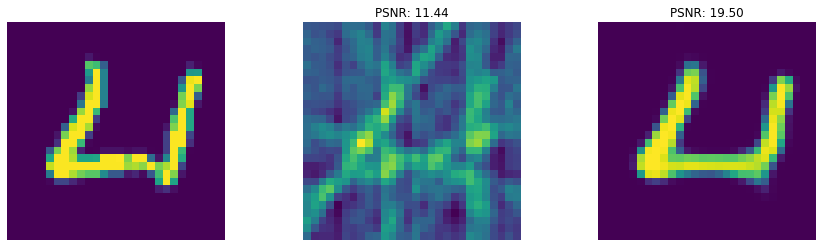

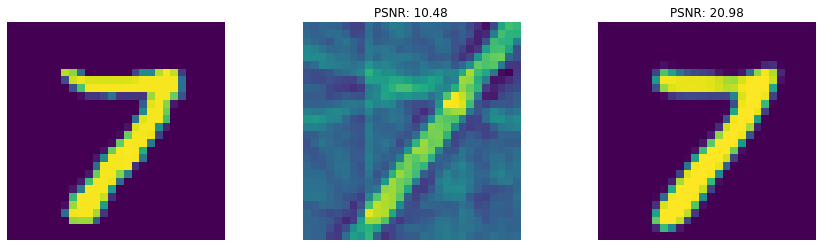

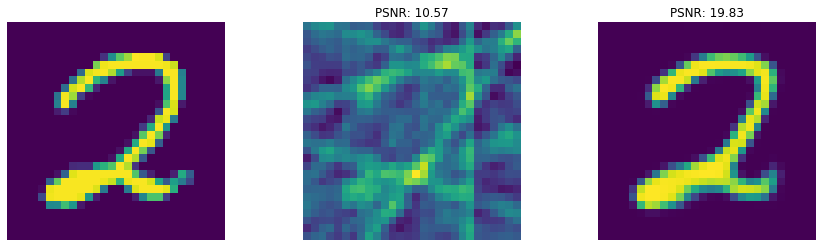

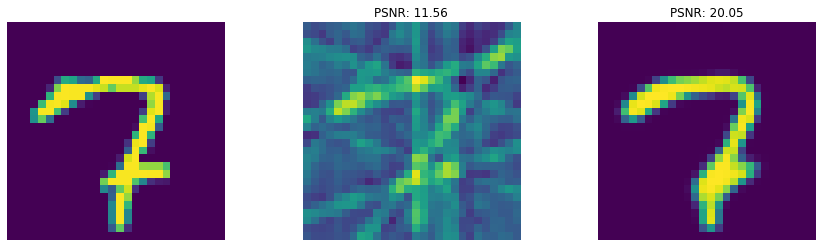

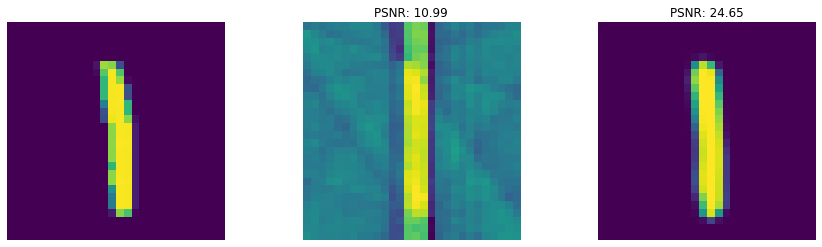

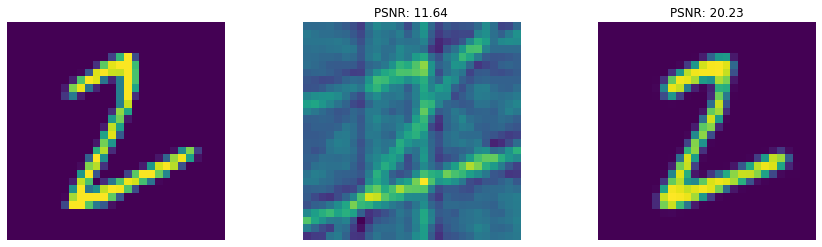

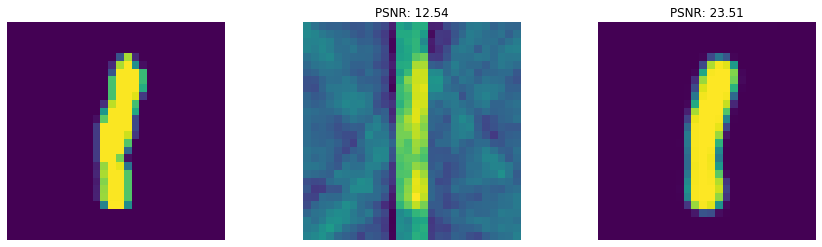

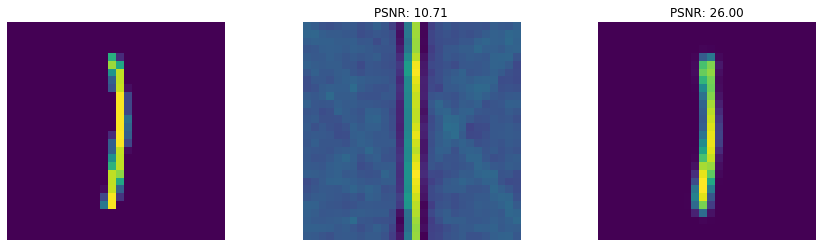

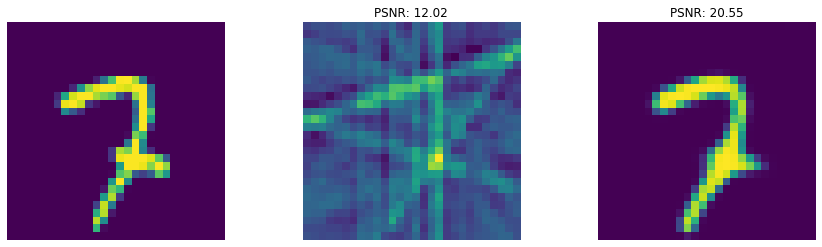

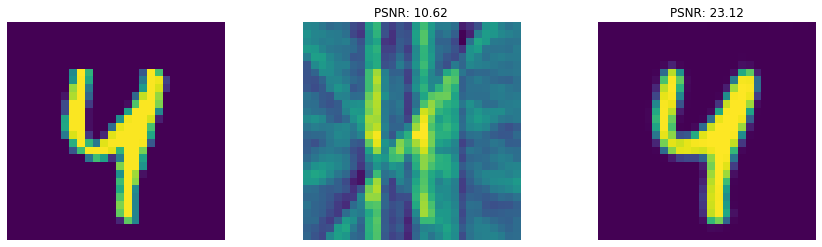

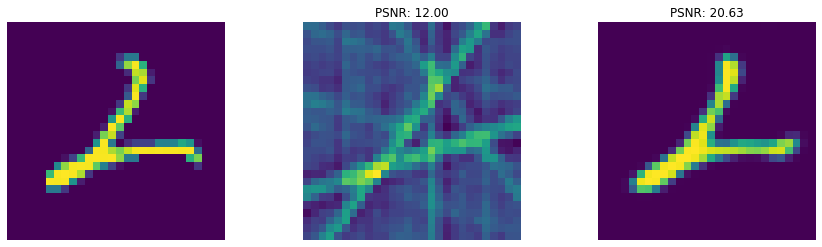

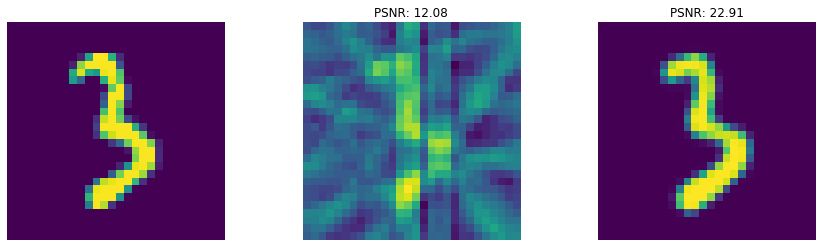

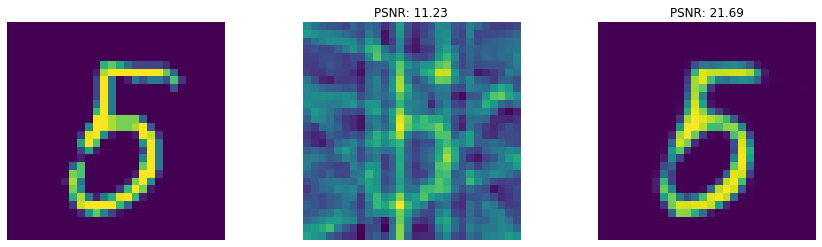

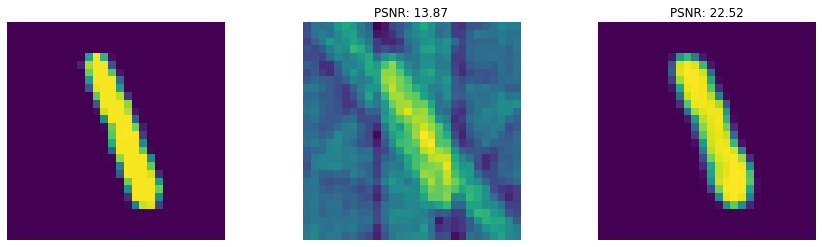

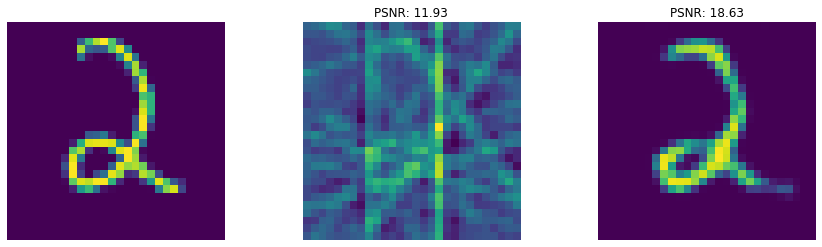

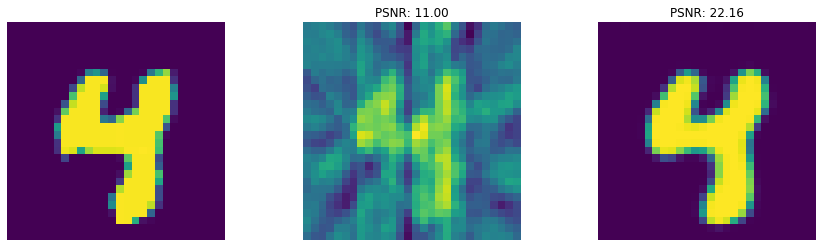

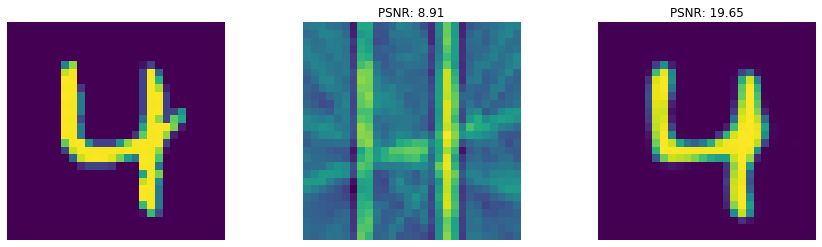

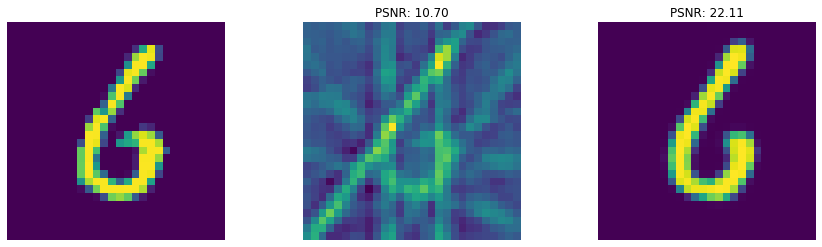

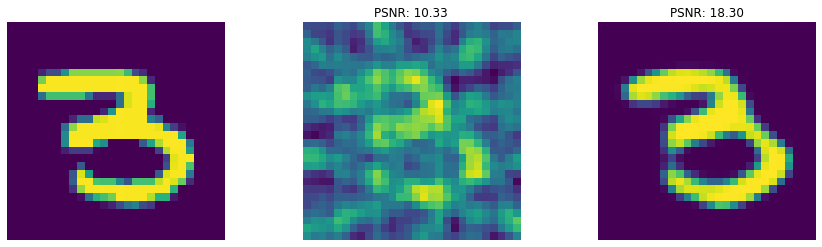

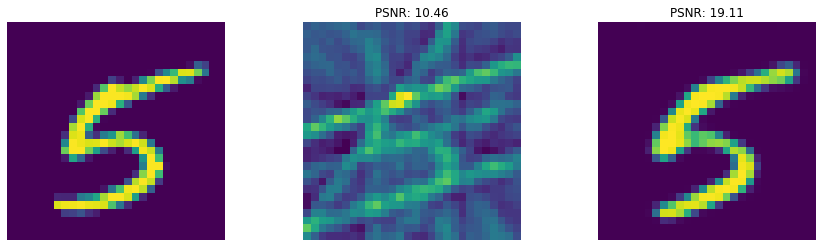

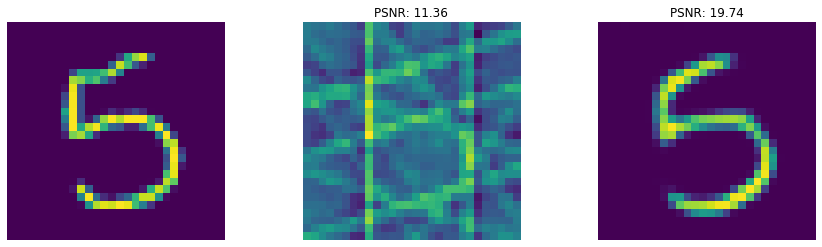

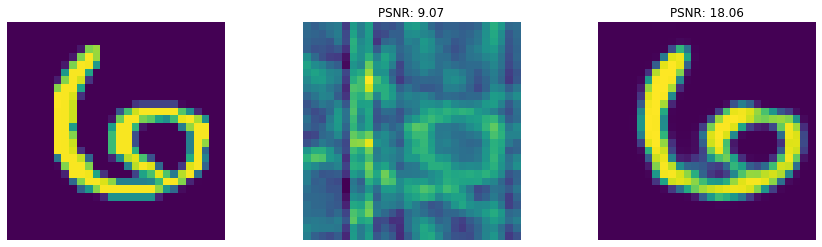

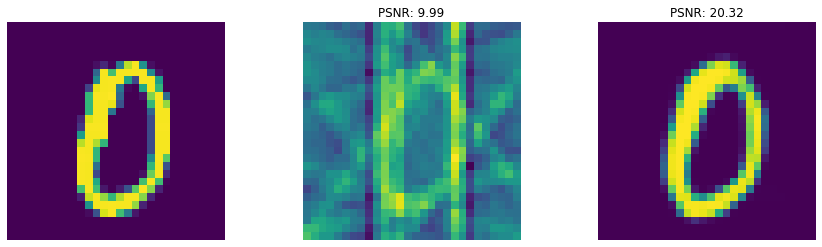

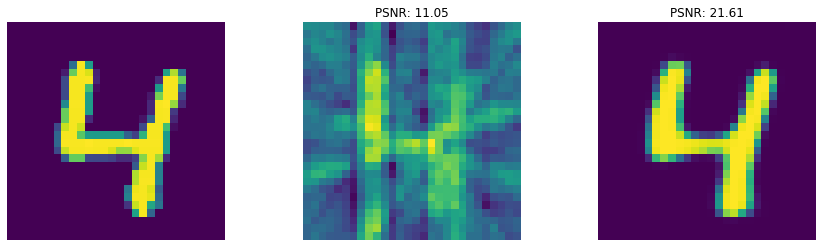

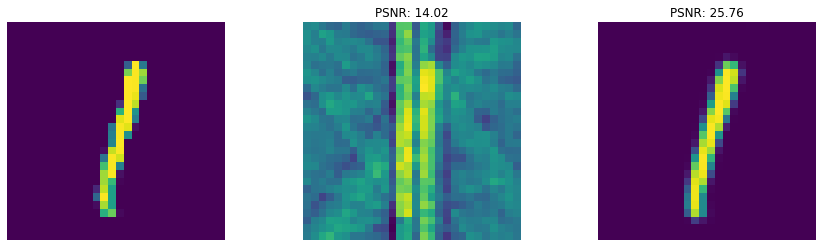

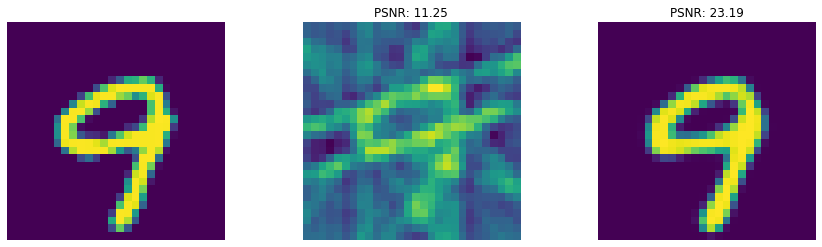

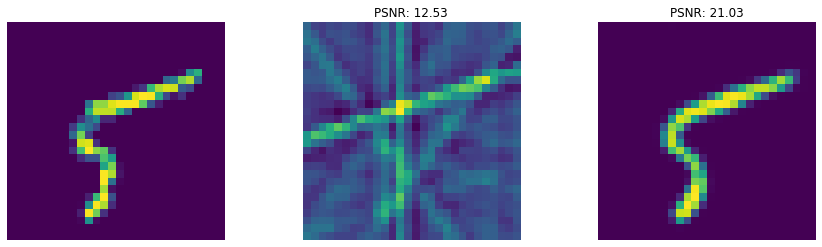

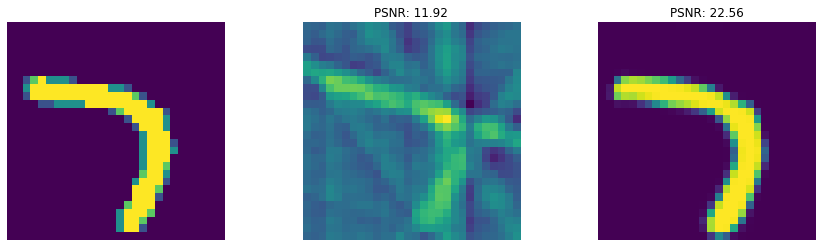

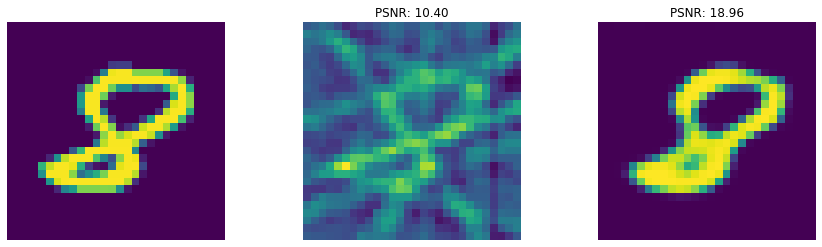

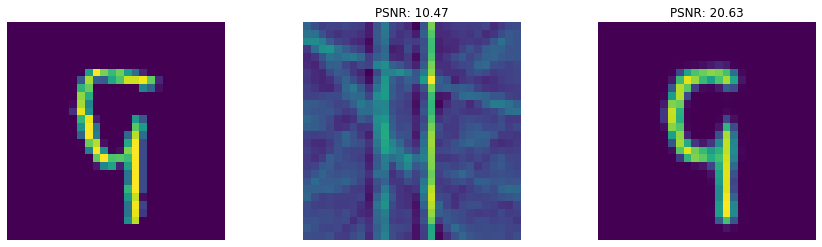

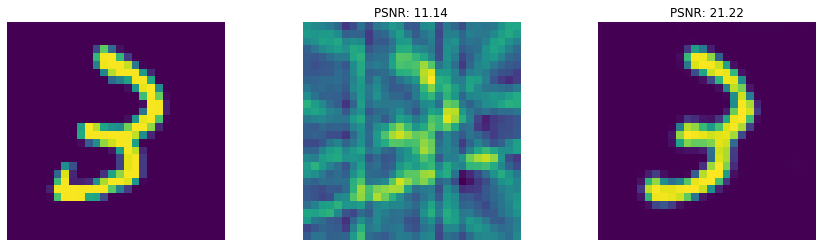

In [12]:
import torch.nn.functional as F
from skimage.transform import iradon


model.to(device)
model.eval()

# first batch of data pairs
x, y, z = next(iter(test_loader))

########################################################
# TODO compute the output of the network
z = z.to(device)
outputs = model(z)
########################################################

for i in range(x.shape[0]):
    plt.figure(figsize=(15, 4))
   
    plt.subplot(1,3,1)
    
    plt.imshow(x[i].squeeze())
    plt.axis('off')
    
    plt.subplot(1,3,2)
    
    x_rec = iradon(y[i].cpu().numpy(), theta, circle=False)
    plt.imshow(x_rec)
    psnr1 = PSNR(x[i][0].cpu().numpy(), x_rec)
    
    plt.title('PSNR: %.2f' % psnr1)
    plt.axis('off')

    plt.subplot(1,3,3)
    psnr2 = PSNR(x[i].cpu().numpy(), outputs[i].detach().cpu().numpy())
    plt.title('PSNR: %.2f' % psnr2)
    
    plt.imshow(outputs[i].detach().cpu().numpy().squeeze())
    plt.axis('off')
    
    plt.show()